### To do:  
* PREPARING DATA: See what has to be done for engineered features (normalisation versus standardization?)
* CHOOSE A BASELINE: for example, prediction=last disease stage

### results so far: 
* Best model: n_epochs=50, optimiser='adam', batch_size=8, input_units=50
* L2 Regularization doesn't change validation accuracy, and is worse for the loss

### To improve model
* Try Irwan's optimizer
* Try with the reduced list of features (relevant features from the RF classifier): but first code all the data processing as a function
* Try with GRU layer instead

### Imports

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
% matplotlib inline

## 1. Data Pre-Processing

In [78]:
### reading processed dataframe
file_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/pre-processing/dfFinal.csv'
df=pd.read_csv(file_path)
df.drop(columns=['Unnamed: 0'],inplace=True)
df.head(2)

,PATNO,EVENT_ID,INFODT,INFODT_date,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,...,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,VISIT_ID,visitsdiff_days,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
0,3001,SC,02/2011,2011-02-01,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,2,7,1,0,2707,306,0,0
1,3001,V04,03/2012,2012-03-01,1.0,0.0,1.0,1.0,1.0,0.0,...,0,0,2,7,2,394,2313,700,0,0


### normalizing continuous features

In [79]:
# save it as a .txt in data_pre-processing and reload it. 
continuous_features=list()
path_features='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/pre-processing/list_continuousFeatures.txt'
with open(path_features, 'r') as f:  
    for line in f:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]
        # add item to the list
        continuous_features.append(currentPlace)

In [80]:
df[continuous_features].head()

,CSFSPNRT,SMPDSCRD,RBCRSLT,WBCRSLT,TOPRRSLT,TGLCRSLT,SYSSUP,DIASUP,HRSUP,SYSSTND,...,AGE_ASSESS_LNS,DVS_LNS,DVSD_SDM,DVT_SDM,SDMTOTAL,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days,lastDate_diff_days,visitsdiff_days
0,1998.8,0,129.1,2.3,45.4,59.2,152.0,90.0,64.0,136.0,...,64.0,12.0,0.000,47.000000,42.0,306,0,0,2707,0
1,2000.0,0,10.0,1.0,38.0,58.0,139.0,83.0,66.0,124.0,...,64.0,12.0,0.000,47.000000,42.0,700,0,0,2313,394
2,2000.0,0,1.0,1.0,39.0,56.0,119.0,72.0,67.0,104.0,...,67.0,18.0,-0.167,48.330002,42.0,1126,0,0,1887,426
3,1998.8,0,129.1,2.3,45.4,59.2,111.0,68.0,76.0,107.0,...,68.0,15.0,0.400,54.000000,48.0,1461,0,0,1552,335
4,2000.0,0,0.0,0.0,36.0,57.0,128.0,81.0,79.0,114.0,...,69.0,18.0,0.400,54.000000,48.0,1826,0,0,1187,365


In [81]:
# see if relevant to do normalization for engineered features - standardization better? 

df[continuous_features]=df[continuous_features].apply(lambda x: x-np.mean(x)/np.std(x))
df[continuous_features].head()

,CSFSPNRT,SMPDSCRD,RBCRSLT,WBCRSLT,TOPRRSLT,TGLCRSLT,SYSSUP,DIASUP,HRSUP,SYSSTND,...,AGE_ASSESS_LNS,DVS_LNS,DVSD_SDM,DVT_SDM,SDMTOTAL,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days,lastDate_diff_days,visitsdiff_days
0,1952.620056,-0.18115,128.747995,2.147378,43.264597,54.002456,144.601095,82.638178,57.726907,128.879238,...,54.965183,6.813539,0.282465,40.982679,37.090282,305.161156,-0.027076,-0.047676,2705.439754,-1.23556
1,1953.820056,-0.18115,9.647995,0.847378,35.864597,52.802456,131.601095,75.638178,59.726907,116.879238,...,54.965183,6.813539,0.282465,40.982679,37.090282,699.161156,-0.027076,-0.047676,2311.439754,392.76444
2,1953.820056,-0.18115,0.647995,0.847378,36.864597,50.802456,111.601095,64.638178,60.726907,96.879238,...,57.965183,12.813539,0.115465,42.312681,37.090282,1125.161156,-0.027076,-0.047676,1885.439754,424.76444
3,1952.620056,-0.18115,128.747995,2.147378,43.264597,54.002456,103.601095,60.638178,69.726907,99.879238,...,58.965183,9.813539,0.682465,47.982679,43.090282,1460.161156,-0.027076,-0.047676,1550.439754,333.76444
4,1953.820056,-0.18115,-0.352005,-0.152622,33.864597,51.802456,120.601095,73.638178,72.726907,106.879238,...,59.965183,12.813539,0.682465,47.982679,43.090282,1825.161156,-0.027076,-0.047676,1185.439754,363.76444


### Selection only patients with more than one visit 

In [18]:
df_2visits=df[df.num_visits>=2]
print(len(df_2visits)/len(df))
print('samples lost: {}'.format((df.shape[0]-df_2visits.shape[0])))
assert len(df_2visits[df_2visits['num_visits']==1])==0

0.8597408026755853
samples lost: 671


### Padding visit sequences for a sequence_length=4 - custom function TO CORRECT

In [19]:
def rows_to_pad(df, num_visits, visit_ID):
    subdf=df[df['num_visits']==num_visits]
    rowstoAdd=subdf.groupby('PATNO').median() 

    # Changing the value of the engineered features
    Engineered_features_max=['PDDXDT_diff_days','PDMEDT_diff_days','PDSURGDT_diff_days']
    Engineered_features_min='lastDate_diff_days'
    rowstoAdd[Engineered_features_max]=subdf.groupby('PATNO').max()[Engineered_features_max]
    rowstoAdd[Engineered_features_min]=subdf.groupby('PATNO').min()[Engineered_features_min]
    rowstoAdd['VISIT_ID']=visit_ID
    rowstoAdd['visitsdiff_days']=3*61 # we assume that the visit we add is three months later

    # updating the engineered values features
    rowstoAdd['lastDate_diff_days']=rowstoAdd['lastDate_diff_days']-rowstoAdd['visitsdiff_days']
    rowstoAdd['PDDXDT_diff_days']=rowstoAdd['PDDXDT_diff_days'].where(rowstoAdd['PDDXDT_diff_days']==0,
                                                                     rowstoAdd['PDDXDT_diff_days']+rowstoAdd['visitsdiff_days'])
    maskMED=rowstoAdd['PDMEDT_diff_days']!=0
    rowstoAdd.loc[maskMED,'PDMEDT_diff_days']=rowstoAdd.loc[maskMED,'PDMEDT_diff_days']+rowstoAdd.loc[maskMED,'visitsdiff_days']
    maskSURG=rowstoAdd['PDSURGDT_diff_days']!=0
    rowstoAdd.loc[maskSURG,'PDSURGDT_diff_days']=rowstoAdd.loc[maskSURG,'PDSURGDT_diff_days']+rowstoAdd.loc[maskSURG,'visitsdiff_days']
    
    return rowstoAdd

def padding_visits_PPMI(df, seq_length=4):

    #number of visits==2
    ## Visit_ID=3
    rowstoAdd=rows_to_pad(df,num_visits=2,visit_ID=3)
    
    #Number of visits==2
    ##Visit_ID==4
    rowstoAdd2=rows_to_pad(df,num_visits=2,visit_ID=4)
    
    #Number of visits==3, visit_ID=4
    rowstoAdd3=rows_to_pad(df,num_visits=3,visit_ID=4)

    # concatenating all the rows to add
    rowspadding=pd.concat([rowstoAdd,rowstoAdd2,rowstoAdd3])
    rowspadding['num_visits']=4
    rowspadding.reset_index(inplace=True)
    #print(rowspadding.shape)

    # reformatting final df
    dfpad_th4=df.drop(columns=['INFODT_date','INFODT','EVENT_ID'])
    dfpad_th4=pd.concat([dfpad_th4,rowspadding])
    # updating the new number of visits for the padded sequences
    dfpad_th4['num_visits'].replace(2,4,inplace=True)
    dfpad_th4['num_visits'].replace(3,4,inplace=True)
    dfpad_th4.reset_index(drop=True,inplace=True)
    dfpad_th4['NHY']=dfpad_th4['NHY'].apply(lambda x: round(x,0)) 
    # APPLY ROUND TO ALL VARIABLE INSTEAD?
    dfpad_th4.sort_values(['PATNO','VISIT_ID'],inplace=True)
    print('df final shape: {}'.format(dfpad_th4.shape))
    print('number final of patients:{}'.format(len(set(dfpad_th4['PATNO']))))
    
    return dfpad_th4

In [20]:
df_4visits=padding_visits_PPMI(df_2visits)

df final shape: (4887, 375)
number final of patients:1003


In [21]:
df_4visits.head()

,PATNO,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,NP2SWAL,...,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,VISIT_ID,visitsdiff_days,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
0,3001,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,7,1,0,2707,306,0,0
1,3001,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,7,2,394,2313,700,0,0
2,3001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,7,3,426,1887,1126,0,0
3,3001,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,7,4,335,1552,1461,0,0
4,3001,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,2.0,7,5,365,1187,1826,0,0


In [22]:
from keras.preprocessing.sequence import pad_sequences
# caution: to pad/trucate sequences, you need to reshape your data first
cols=list(df_4visits.columns)
cols.remove('PATNO')
df_reshaped=pd.DataFrame()
for col in cols:
    ser_col=df_4visits.groupby('PATNO')[col].apply(list)
    keys=list(df.columns).append(col)
    df_reshaped=pd.concat([df_reshaped,ser_col],axis=1,keys=keys)

df_reshaped.head()

Using TensorFlow backend.


,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,...,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,VISIT_ID,visitsdiff_days,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
PATNO,,,,,,,,,,,,,,,,,,,,,
3001,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]","[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]","[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0]",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]","[7, 7, 7, 7, 7, 7, 7]","[1, 2, 3, 4, 5, 6, 7]","[0, 394, 426, 335, 365, 427, 638]","[2707, 2313, 1887, 1552, 1187, 760, 122]","[306, 700, 1126, 1461, 1826, 2253, 2891]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]"
3002,"[1.0, 1.0, 2.0, 1.0, 2.0, 1.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[1.0, 1.0, 3.0, 0.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 2.0, 1.0, 1.0]","[0.0, 0.0, 2.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[1.0, 2.0, 1.0, 2.0, 0.0, 2.0]","[0.0, 2.0, 1.0, 3.0, 3.0, 3.0]","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 2.0, 1.0, 1.0, 2.0, 1.0]",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[6, 6, 6, 6, 6, 6]","[1, 2, 3, 4, 5, 6]","[0, 397, 365, 699, 397, 730]","[2679, 2282, 1917, 1218, 821, 91]","[393, 790, 1155, 1854, 2251, 2981]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]"
3003,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0]","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]",...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]","[7, 7, 7, 7, 7, 7, 7]","[1, 2, 3, 4, 5, 6, 7]","[0, 397, 365, 365, 365, 366, 365]","[2679, 2282, 1917, 1552, 1187, 821, 456]","[730, 1127, 1492, 1857, 2222, 2588, 2953]","[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]"
3006,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.5, 0.5]","[1.0, 1.0, 1.0, 1.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[2.0, 3.0, 2.5, 2.5]","[0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0]",...,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[2.0, 2.0, 2.0, 2.0]","[4, 4, 4, 4]","[1, 2, 3, 4]","[0, 427, 183, 183]","[2679, 2252, 2069, 2069]","[120, 547, 730, 730]","[0, 0, 0, 0]","[0, 0, 0, 0]"
3010,"[1.0, 0.0, 0.0, 1.0, 0.0, 1.0]","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 1.0, 0.0, 3.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 2.0, 2.0, 1.0, 2.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 2.0, 3.0, 2.0, 2.0, 3.0]","[1.0, 2.0, 3.0, 2.0, 2.0, 3.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 1.0]","[0.0, 1.0, 2.0, 2.0, 1.0, 1.0]",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[6, 6, 6, 6, 6, 6]","[1, 2, 3, 4, 5, 6]","[30, 397, 395, 427, 273, 519]","[2618, 2221, 1826, 1399, 1126, 607]","[89, 486, 881, 1308, 1581, 2100]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]"


In [23]:
target=df_reshaped['NHY']
data=df_reshaped.values

target_truncated=pad_sequences(target,maxlen=4)
target_final=target_truncated[:,3]
#target_final.reshape((target_final.shape[0],1))
target_final.shape

(1003,)

In [24]:
data_truncated=np.zeros(shape=(data.shape[0],data.shape[1],3),dtype=int)
for i in range(data.shape[1]):
    # take the last 4 sequences
    seq_truncated_col=pad_sequences(data[:,i],maxlen=4)
    # remove the last sequence (visit to predict)
    seq_truncated_col=pad_sequences(seq_truncated_col,maxlen=3,truncating='post')
    data_truncated[:,i]=seq_truncated_col
data_truncated[0]

array([[   0,    0,    1],
       [   0,    0,    0],
       [   0,    0,    1],
       ...,
       [1461, 1826, 2253],
       [   0,    0,    0],
       [   0,    0,    0]])

In [25]:
print(data_truncated.shape)
data_final=np.transpose(data_truncated,axes=(0,2,1))
data_final.shape # final data shape: (num_of_samples, number_of_timesteps, number of features)

(1003, 374, 3)


(1003, 3, 374)

In [26]:
set(target_final)

{0, 1, 2, 3, 4, 5}

## 2. Split the dataset train/test/val

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import sklearn.cross_validation as cv

/Users/alicemartin/miniconda3/envs/project/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [28]:
from keras.utils import to_categorical
target_final=to_categorical(target_final,num_classes=6,dtype='int32')
print(target_final.shape)
target_final[:2]

(1003, 6)


array([[0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0]], dtype=int32)

In [29]:
X_train, X_test=train_test_split(data_final, test_size=0.2, random_state=0)
y_train, y_test=train_test_split(target_final, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(802, 3, 374)
(201, 3, 374)
(802, 6)


## 3. LSTM model (simple vanilla LSTM model)

In [30]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

### Defining and compiling the model

In [69]:
n_class=6
seq_length=3
n_features=374

### hyperparameters to optimize
optimizer='adam'
input_units=50
n_epochs=50
batch_size=8

model=Sequential()
model.add(LSTM(input_units, input_shape=(seq_length,n_features)))
model.add(Dense(n_class, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 50)                85000     
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 306       
Total params: 85,306
Trainable params: 85,306
Non-trainable params: 0
_________________________________________________________________
None


### fit the model

In [65]:
history=model.fit(X_train, y_train, batch_size=batch_size,epochs=n_epochs,validation_split=0.2)

Train on 641 samples, validate on 161 samples
Epoch 1/100
641/641 [==============================] - 3s 5ms/step - loss: 1.1487 - acc: 0.6583 - val_loss: 0.8752 - val_acc: 0.8012
Epoch 2/100
641/641 [==============================] - 1s 1ms/step - loss: 0.8416 - acc: 0.7707 - val_loss: 0.7743 - val_acc: 0.8012
Epoch 3/100
641/641 [==============================] - 1s 1ms/step - loss: 0.7841 - acc: 0.7785 - val_loss: 0.7290 - val_acc: 0.7888
Epoch 4/100
641/641 [==============================] - 1s 1ms/step - loss: 0.7611 - acc: 0.7800 - val_loss: 0.7217 - val_acc: 0.7888
Epoch 5/100
641/641 [==============================] - 1s 1ms/step - loss: 0.7477 - acc: 0.7832 - val_loss: 0.7320 - val_acc: 0.7888
Epoch 6/100
641/641 [==============================] - 1s 1ms/step - loss: 0.7485 - acc: 0.7800 - val_loss: 0.7467 - val_acc: 0.7764
Epoch 7/100
641/641 [==============================] - 1s 1ms/step - loss: 0.7477 - acc: 0.7800 - val_loss: 0.7675 - val_acc: 0.7826
Epoch 8/100
641/641 [==

Epoch 62/100
641/641 [==============================] - 1s 2ms/step - loss: 0.7263 - acc: 0.7863 - val_loss: 0.7167 - val_acc: 0.7888
Epoch 63/100
641/641 [==============================] - 1s 1ms/step - loss: 0.7228 - acc: 0.7878 - val_loss: 0.7151 - val_acc: 0.7888
Epoch 64/100
641/641 [==============================] - 1s 1ms/step - loss: 0.7267 - acc: 0.7863 - val_loss: 0.7305 - val_acc: 0.7888
Epoch 65/100
641/641 [==============================] - 1s 1ms/step - loss: 0.7265 - acc: 0.7863 - val_loss: 0.7254 - val_acc: 0.7888
Epoch 66/100
641/641 [==============================] - 1s 1ms/step - loss: 0.7289 - acc: 0.7878 - val_loss: 0.7401 - val_acc: 0.7888
Epoch 67/100
641/641 [==============================] - 1s 1ms/step - loss: 0.7234 - acc: 0.7878 - val_loss: 0.7149 - val_acc: 0.7888
Epoch 68/100
641/641 [==============================] - 1s 1ms/step - loss: 0.7136 - acc: 0.7894 - val_loss: 0.7275 - val_acc: 0.7888
Epoch 69/100
641/641 [==============================] - 1s 1ms

### Displaying training and validation loss

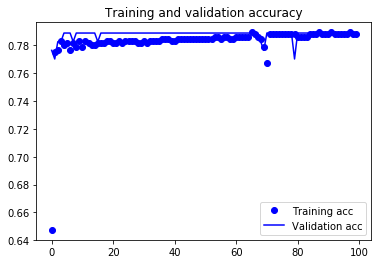

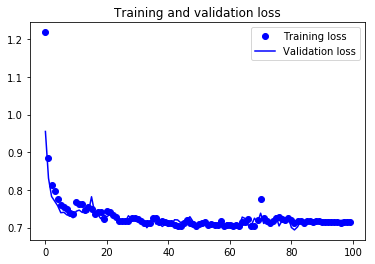

In [63]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### adding a regularizer

In [70]:
from keras import regularizers
model_reg=Sequential()
model_reg.add(LSTM(input_units, input_shape=(seq_length,n_features)))
model_reg.add(Dense(n_class, activation='softmax',kernel_regularizer=regularizers.l2(0.001)))
model_reg.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
print(model_reg.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 50)                85000     
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 306       
Total params: 85,306
Trainable params: 85,306
Non-trainable params: 0
_________________________________________________________________
None


In [71]:
history_reg=model_reg.fit(X_train, y_train, batch_size=batch_size,epochs=n_epochs,validation_split=0.2)

Train on 641 samples, validate on 161 samples
Epoch 1/50
641/641 [==============================] - 3s 5ms/step - loss: 1.4224 - acc: 0.4680 - val_loss: 1.0124 - val_acc: 0.7205
Epoch 2/50
641/641 [==============================] - 1s 1ms/step - loss: 0.9858 - acc: 0.7566 - val_loss: 0.8536 - val_acc: 0.7826
Epoch 3/50
641/641 [==============================] - 1s 1ms/step - loss: 0.8620 - acc: 0.7800 - val_loss: 0.7976 - val_acc: 0.7888
Epoch 4/50
641/641 [==============================] - 1s 2ms/step - loss: 0.8170 - acc: 0.7832 - val_loss: 0.7652 - val_acc: 0.7888
Epoch 5/50
641/641 [==============================] - 1s 2ms/step - loss: 0.7943 - acc: 0.7816 - val_loss: 0.7639 - val_acc: 0.7888
Epoch 6/50
641/641 [==============================] - 1s 1ms/step - loss: 0.7842 - acc: 0.7832 - val_loss: 0.7431 - val_acc: 0.7888
Epoch 7/50
641/641 [==============================] - 1s 2ms/step - loss: 0.7687 - acc: 0.7832 - val_loss: 0.7406 - val_acc: 0.7888
Epoch 8/50
641/641 [==========

In [75]:
relevant_features=list()
path_features='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/ML_predictions/list_relevantFeatures.txt'
with open(path_features, 'r') as f:  
    for line in f:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]
        # add item to the list
        relevant_features.append(currentPlace)

In [76]:
relevant_features

['NHY',
 'PDDXDT_diff_days',
 'DOMSIDE',
 'DFBRADYP',
 'DFRIGIDP',
 'PRIMDIAG',
 'APPRDX',
 'NP3FACXP',
 'NP3BRADY',
 'DFBRADYA',
 'DXTREMOR',
 'NP3TTAPL',
 'DFRIGIDA',
 'NP3FTAPL',
 'lastDate_diff_days',
 'BIRTHDT',
 'ON_OFF_DOSE',
 'CURRENT_APPRDX',
 'NP3PRSPL',
 'DIASTND',
 'NP3FTAPR',
 'SYSSTND',
 'PD_MED_USE',
 'SYSSUP',
 'NP3HMOVL',
 'DIASUP',
 'NP3RTCON',
 'NP3PSTBL',
 'HRSTND',
 'NP3RIGN',
 'HRSUP',
 'NP3RIGLU',
 'PDMEDYN',
 'NP3RIGRU',
 'NP2WALK',
 'NP3TTAPR',
 'NP2TRMR',
 'NP3SPCH',
 'num_visits',
 'NP2HWRT',
 'DXBRADY',
 'NP3LGAGL',
 'NP2DRES',
 'NP2SPCH',
 'MHROW_2',
 'NP3RISNG',
 'DFRTREMA',
 'NP3GAIT',
 'NP3POSTR',
 'visitsdiff_days',
 'NP3HMOVR',
 'PN3RIGRL',
 'TOPRRSLT',
 'DXRIGID',
 'DFPGDIST',
 'NP3RTALU',
 'NP2RISE',
 'NP3PRSPR',
 'DVS_JLO_MSSAE',
 'AGE_ASSESS_LNS',
 'NP2TURN',
 'NP3LGAGR',
 'AGE_ASSESS_JLO',
 'VISIT_ID',
 'DVT_SDM',
 'NP3RIGLL',
 'DVT_RETENTION',
 'MHROW_3',
 'NP2HOBB',
 'TGLCRSLT',
 'SDMTOTAL',
 'RBCRSLT',
 'NP1COG',
 'NP2HYGN',
 'DVT_DELAYED_RECAL

In [34]:
loss,acc=model.evaluate(x=X_test,y=y_test) # to evaluate on validation_set 